Drop Cognitive and Functional Assessments
MMSE: Mini-Mental State Examination score, ranging from 0 to 30. Lower scores indicate cognitive impairment.
FunctionalAssessment: Functional assessment score, ranging from 0 to 10. Lower scores indicate greater impairment.
MemoryComplaints: Presence of memory complaints, where 0 indicates No and 1 indicates Yes.
BehavioralProblems: Presence of behavioral problems, where 0 indicates No and 1 indicates Yes.
ADL: Activities of Daily Living score, ranging from 0 to 10. Lower scores indicate greater impairment

and patitant ID. 
PatientID  

In [21]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import seaborn as sns

# Download the latest version of the dataset
dataset_path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")

print("Dataset path:", dataset_path)

# List files in the dataset directory
files = os.listdir(dataset_path)
print("Files in dataset:", files)

# Choose the correct CSV file (replace 'your_file.csv' with the actual file name)
csv_file = [f for f in files if f.endswith('.csv')]
if not csv_file:
    raise FileNotFoundError("No CSV file found in the dataset directory.")
csv_file_path = os.path.join(dataset_path, csv_file[0])

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows
print(df.head())


Dataset path: C:\Users\jimco\.cache\kagglehub\datasets\rabieelkharoua\alzheimers-disease-dataset\versions\1
Files in dataset: ['alzheimers_disease_data.csv']
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...            

In [22]:
# 2.1 Initial Data Inspection
print(df.info())  # Check data types and missing values
print(df.describe()) # Basic statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [23]:
print(df.columns)

df['Diagnosis'].value_counts()

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')


Diagnosis
0    1389
1     760
Name: count, dtype: int64

In [24]:
# df['Diagnosis'] = df['Diagnosis'].astype(int)

In [26]:
# 2.2 Identify Non-Numeric Columns and Handle Missing Values:

# Identify columns with non-numeric data
non_numeric_cols = df.select_dtypes(exclude=['number']).columns

print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['DoctorInCharge'], dtype='object')


In [27]:
df = df.drop(['DoctorInCharge', 'PatientID', 'FunctionalAssessment', 'ADL', 'MMSE'], axis=1)  # Drop the non-numeric column

In [28]:
print(df.head())  # Check the DataFrame after dropping the column

   Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   73       0          0               2  22.927749        0   
1   89       0          0               0  26.827681        0   
2   73       0          3               1  17.795882        0   
3   74       1          0               1  33.800817        1   
4   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0           13.297218          6.327112     1.347214      9.025679  ...   
1            4.542524          7.619885     0.518767      7.151293  ...   
2           19.555085          7.844988     1.826335      9.673574  ...   
3           12.209266          8.428001     7.435604      8.392554  ...   
4           18.454356          6.310461     0.795498      5.597238  ...   

   CholesterolHDL  CholesterolTriglycerides  MemoryComplaints  \
0       33.682563                162.189143                 0   
1       79.028477           

In [29]:
#2.3 Handling Missing Values:
# Impute missing values using mean or median
imputer = SimpleImputer(strategy='mean')  # Or 'median'
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns  # Select all numerical columns
df[numerical_features] = imputer.fit_transform(df[numerical_features])
# Verify that all missing values have been handled
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MemoryComplaints             0
BehavioralProblems           0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfulness                0
Diagnosis                    0
dtype: int64


In [30]:
# 2.4 Feature Scaling:
# Scale numerical features using StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

#Verify transformation
print(df.head())

        Age    Gender  Ethnicity  EducationLevel       BMI   Smoking  \
0 -0.212368 -1.012644  -0.700408        0.788833 -0.655225 -0.636784   
1  1.567757 -1.012644  -0.700408       -1.422782 -0.114751 -0.636784   
2 -0.212368 -1.012644   2.311955       -0.316974 -1.366428 -0.636784   
3 -0.101111  0.987514  -0.700408       -0.316974  0.851625  1.570391   
4  1.567757 -1.012644  -0.700408       -1.422782 -0.961607 -0.636784   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            0.565923          0.492525    -1.253593      1.119918  ...   
1           -0.954895          0.945093    -1.538442      0.056836  ...   
2            1.653006          1.023896    -1.088855      1.487380  ...   
3            0.376930          1.227995     0.839804      0.760833  ...   
4            1.461793          0.486696    -1.443293     -0.824566  ...   

   CholesterolHDL  CholesterolTriglycerides  MemoryComplaints  \
0       -1.114429                 -0.648199        

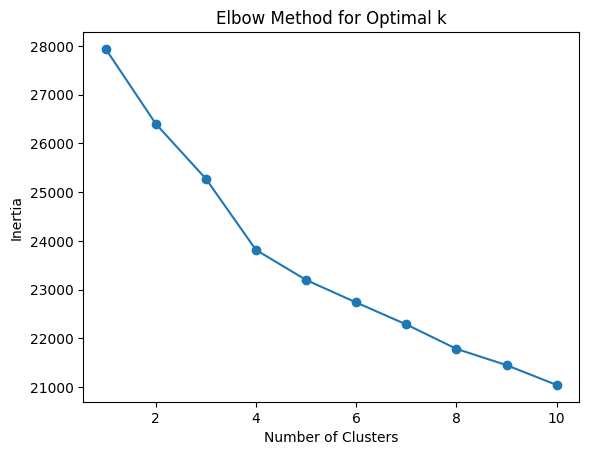

In [31]:
#  3. Clustering with K-Means (using numerical data):

# 3.1 Choose Features for Clustering
cluster_features = ['Age', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']  # Add more features as needed
#Ensure that only available features are being used
cluster_features = [feature for feature in cluster_features if feature in df.columns]

X_cluster = df[cluster_features]

# 3.2 Determine the Optimal Number of Clusters (Elbow Method)

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init = 'auto')  # Added n_init
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

#Based on the plot, determine what the optimal k value will be


In [32]:
# 3.3 Apply K-Means Clustering
n_clusters = 5  # Replace with your chosen optimal number of clusters from the Elbow Method
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 'auto')
df['Cluster'] = kmeans.fit_predict(X_cluster)

# 3.4 Analyze Clusters
print(df['Cluster'].value_counts()) # See cluster sizes


Cluster
3    616
4    420
0    395
2    360
1    358
Name: count, dtype: int64


              Age    Gender  Ethnicity  EducationLevel       BMI   Smoking  \
Cluster                                                                      
0       -0.428969 -0.010033  -0.014047        0.094554 -0.266832 -0.636784   
1       -0.094273 -0.101958  -0.032864       -0.032800  0.117315 -0.636784   
2        0.094518  0.065219  -0.103514       -0.028236  0.250695 -0.624522   
3        0.027667  0.029646   0.047792       -0.017185  0.029965  1.570391   
4        0.362199 -0.003040   0.059855       -0.011561 -0.107878 -0.626274   

         AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
Cluster                                                                   ...   
0                  0.064828          0.048744    -0.472699     -0.374110  ...   
1                 -0.168751          0.000313    -0.596960      0.026688  ...   
2                 -0.046390         -0.086859     0.379374     -0.491872  ...   
3                  0.012414          0.021377   

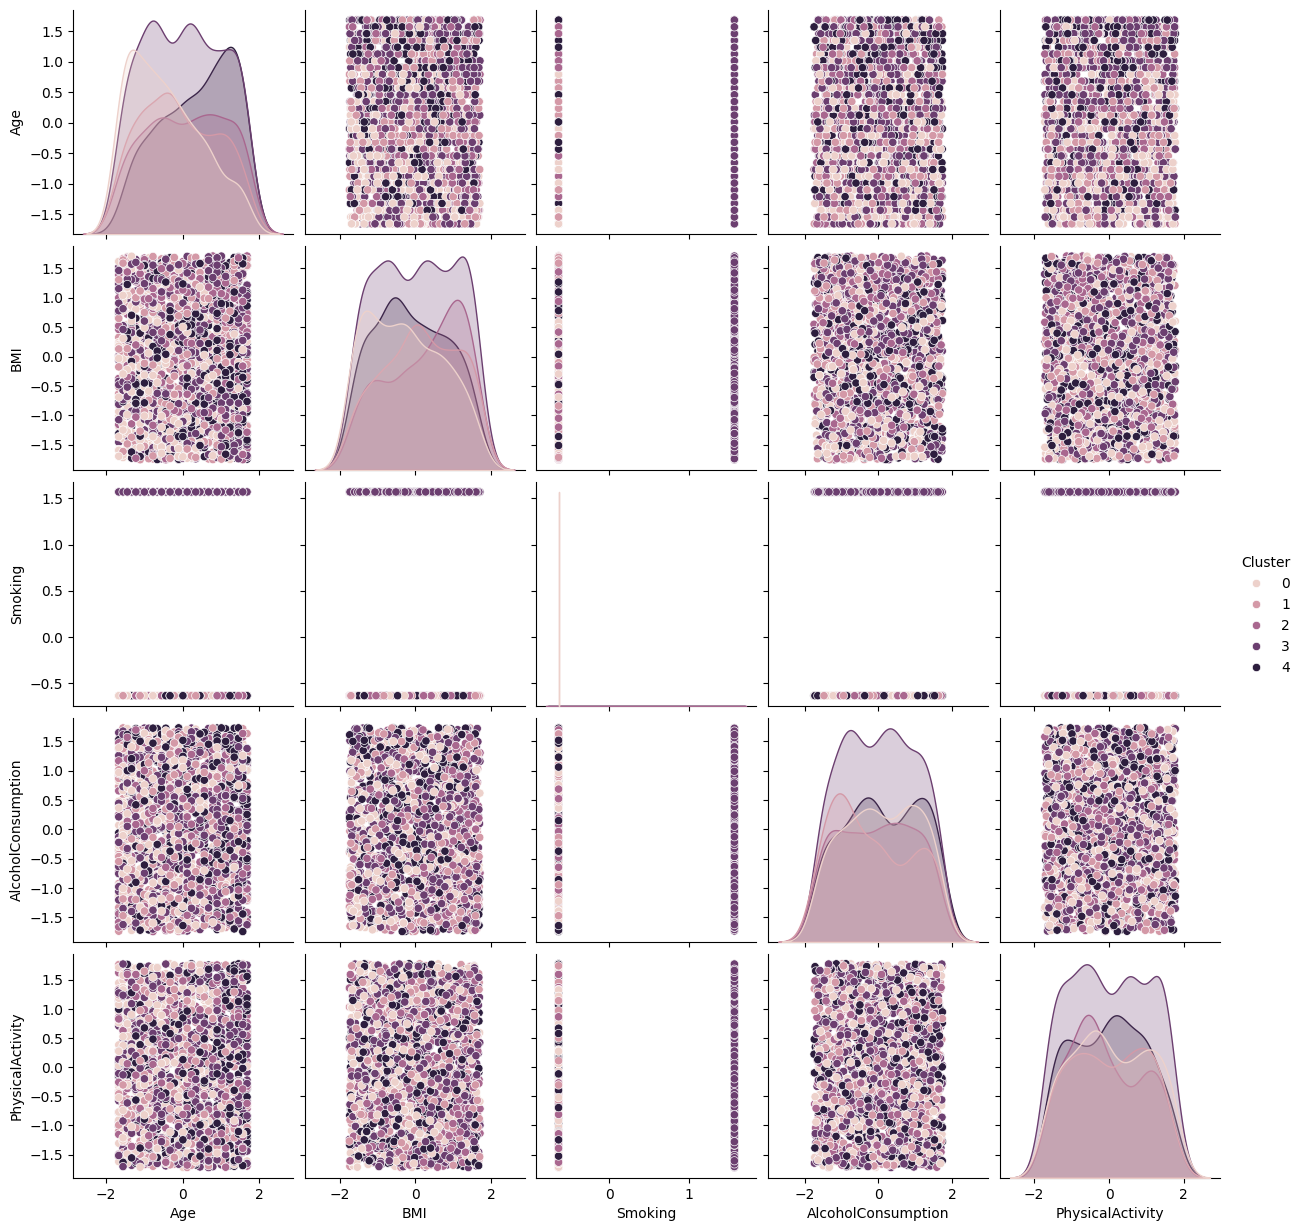

Accuracy: 0.6822
              precision    recall  f1-score   support

           0       0.69      0.88      0.78       401
           1       0.65      0.35      0.46       244

    accuracy                           0.68       645
   macro avg       0.67      0.62      0.62       645
weighted avg       0.67      0.68      0.65       645



In [10]:
# Aggregate Statistics by Cluster
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

#Visualize the clusters, this is optional and you can change the features
sns.pairplot(df, hue='Cluster', vars=cluster_features[:5])  # Adjust vars for different features
plt.show()

# 4. Classification Model (Random Forest):

# 4.1 Prepare Data for Classification

X = df.drop('Diagnosis', axis=1)  # Features (including the 'Cluster' feature)
y = df['Diagnosis']  # Target variable

# 4.2 Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4.3 Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
rf_classifier.fit(X_train, y_train)

# 4.4 Make Predictions
y_pred = rf_classifier.predict(X_test)

# 4.5 Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

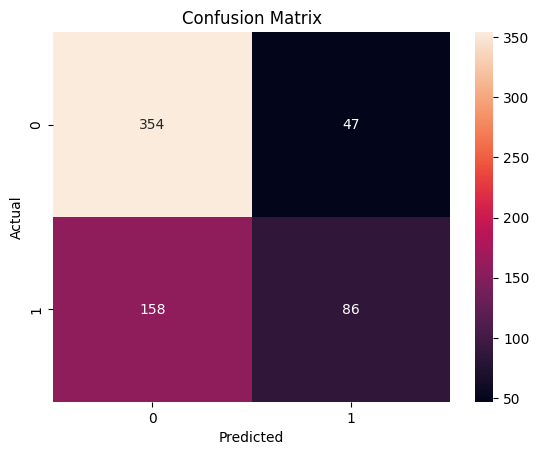

                      Feature  Importance
22           MemoryComplaints    0.078274
4                         BMI    0.066805
18           CholesterolTotal    0.066283
21   CholesterolTriglycerides    0.065448
8                 DietQuality    0.063753
9                SleepQuality    0.062673
20             CholesterolHDL    0.062559
6          AlcoholConsumption    0.060671
19             CholesterolLDL    0.060514
7            PhysicalActivity    0.058119
16                 SystolicBP    0.056994
17                DiastolicBP    0.055840
0                         Age    0.048704
23         BehavioralProblems    0.040035
3              EducationLevel    0.019576
29                    Cluster    0.019462
2                   Ethnicity    0.017581
1                      Gender    0.009606
28              Forgetfulness    0.008820
10    FamilyHistoryAlzheimers    0.008427
27  DifficultyCompletingTasks    0.007974
24                  Confusion    0.007717
13                 Depression    0

: 

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4.6 Feature Importance
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df)
